## AlexNet

AlexNet[1] 与 LeNet 有很多相似之处，但是也有一些很重要的改进，比如，使用了 ReLu 激活函数替代 sigmoid 激活函数，提升了训练速度；使用 Dropout 缓解了过拟合；使用了局部响应标准化 LRN；增加了训练上的技巧以及远超于 LenNet 的网络规模（6000 万个参数和 65 万个神经元）等，也正因此使得其在 2012 年的 ImageNet 竞赛取得了冠军。

本节也是在第 11 节的 baseline 代码基础上进行改进，同样也是使用 Fashion MNIST 数据集进行训练（关于 Fashion MNIST 数据的信息可查看第 10 节）。因此也会在原版本的基础上做出一些调整。网络共 8 层（不算输入层）：5 层卷积层和 3 层全连接层

**注** CBAPD 即 **C**onvolutional、**B**atch Normalization、**A**ctivation、**P**ooling、**D**ropout

 + 第一层：卷积层
  + C：使用 96 个 $3\times3$ 的卷积核，步长为 1，不使用全 0 填充（valid）
  + B：使用批标准化 Batch Normalization（原论文使用的是局部响应标准化 LRN（Local Response Normalization），两者功能相似，故这里使用了更常见的 BN）
  + A：使用 ReLu 激活函数
  + P：使用 $3\times3$ 的池化核，采用最大值池化，步长为 2
  + D：不使用 Dropout
 + 第二层：卷积层
  + C：使用 256 个 $3\times3$ 的卷积核，步长为 1，不使用全 0 填充（valid）
  + B：使用批标准化 Batch Normalization
  + A：使用 ReLu 激活函数
  + P：使用 $3\times3$ 的池化核，采用最大值池化，步长为 2
  + D：不使用 Dropout
 + 第三层：卷积层
  + C：使用 384 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
  + B：不使用批标准化
  + A：使用 ReLu 激活函数
  + P：不使用池化
  + D：不使用 Dropout
 + 第四层：卷积层
  + C：使用 384 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
  + B：不使用批标准化
  + A：使用 ReLu 激活函数
  + P：不使用池化
  + D：不使用 Dropout
 + 第五层：卷积层
  + C：使用 256 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
  + B：不使用批标准化
  + A：使用 ReLu 激活函数
  + P：使用 $3\times3$ 的池化核，采用最大值池化，步长为 2
  + D：不使用 Dropout
 + Flatten 拉伸卷积层传来的输入特征 
 + 第六层：全连接层
  + 4096 个神经元
  + 使用 ReLu 激活函数 
  + 使用值为 0.5 的 Dropout
 + 第七层：全连接层
  + 4096 个神经元
  + 使用 ReLu 激活函数 
  + 使用值为 0.5 的 Dropout
 + 第八层：全连接层（输出层）
  + 10 个神经元
  + 使用 softmax 激活函数
 
原论文中输出层的神经元个数为 1000，但我们使用的是 Fashion MNIST 数据集，只有 10 个类别。
 
+ [1] Krizhevsky A , Sutskever I , Hinton G E . Imagenet classification with deep convolutional neural networks[J]. Advances in neural information processing systems, 2012, 25(2).

In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

实现 AlexNet 网络模型

In [2]:
alexnet8 = [
    Conv2D(filters=96, kernel_size=(3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')                                                    
]

训练步骤依然是之前扩展的“六步法”

In [4]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [5]:
# AlexNet8
model = tf.keras.models.Sequential(alexnet8)

In [6]:
# 配置模型参数
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [7]:
# 设置断点续训
checkpoint_save_path = './checkpoint/AlexNet8.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [8]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True)

In [9]:
# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    validation_freq=1,
                    callbacks=[cp_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 833s 14ms/sample - loss: 0.6024 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.8303 - val_sparse_categorical_accuracy: 0.6864
Epoch 2/5
60000/60000 [==============================] - 865s 14ms/sample - loss: 0.3634 - sparse_categorical_accuracy: 0.8702 - val_loss: 0.3893 - val_sparse_categorical_accuracy: 0.8574
Epoch 3/5
60000/60000 [==============================] - 830s 14ms/sample - loss: 0.3186 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.3598 - val_sparse_categorical_accuracy: 0.8657
Epoch 4/5
60000/60000 [==============================] - 801s 13ms/sample - loss: 0.2900 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.3759 - val_sparse_categorical_accuracy: 0.8525
Epoch 5/5
60000/60000 [==============================] - 916s 15ms/sample - loss: 0.2733 - sparse_categorical_accuracy: 0.9004 - val_loss: 0.3242 - val_sparse_categorical_accuracy: 0.8868


In [10]:
# 打印网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  960       
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  221440    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  1024      
_________________________________________________________________
activation_1 (Activation)    multiple                  0

In [11]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [12]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

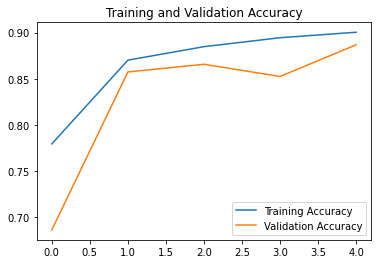

In [13]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

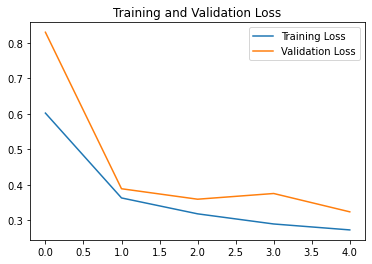

In [14]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()